# Tutorial 2: Stereo-seq Mouse embryo

In this section, we demonstrate how to use **SpaCross** to jointly analyze mouse embryonic spatial transcriptomics data across multiple developmental stages (E9.5, E10.5, and E11.5), all generated using the **Stereo-seq** platform.

SpaCross enables the identification of tissue regions that are either shared across stages (developmentally consistent) or specific to certain stages (emerging or regressing).  
Through cross-stage clustering, SpaCross identifies **20 spatial domains** representing both conserved and dynamic tissue structures.

The mouse embryo spatial transcriptomic data obtained with Stereo-seq technology can be downloaded from https://db.cngb.org/stomics/mosta/.

# [1] Loading packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import torch
import pandas as pd
import scanpy as sc
import matplotlib
from matplotlib import pyplot as plt
import yaml
from pathlib import Path
import os
from sklearn.decomposition import PCA

In [2]:
import SpaCross as TOOLS

# [2] Loading configuration

In [3]:
# loads a YAML configuration file that defines key settings such as data preprocess, model architecture, and training hyperparameters.
with open('../Config/ME3.yaml', 'r', encoding='utf-8') as f:
    config = yaml.load(f.read(), Loader=yaml.FullLoader)

# [3] Basic settings

In [4]:
# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['R_HOME'] = 'D:/software/R/R-4.3.2'
os.environ['R_USER'] = 'D:/software/anaconda/anaconda3/envs/pt20cu118/Lib/site-packages/rpy2'
# the number of clusters
Dataset_name = "MouseEmbryo"
use_sections = ['E9.5_E1S1', 'E10.5_E2S1', 'E11.5_E1S1']
num_clusters = 20
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# sets the data loading path; please modify it according to the actual location of your dataset.
data_root = r"C:\Users\DELL\datasets\MouseEmbryo/"

# [4] Loading data

In [5]:
Batch_list = []
for slice_id, proj_name in enumerate(use_sections):
    adata = sc.read_h5ad(os.path.join(data_root + proj_name + ".MOSTA.h5ad"))
    adata.var_names_make_unique()
    adata.obs_names = [x + '_' + proj_name for x in adata.obs_names]
    ##### Load layer_guess label, if have
    adata.obs['ground_truth'] = adata.obs['annotation']
    adata.obs['slice_id'] = slice_id
    adata.layers['count'] = adata.X
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.filter_genes(adata, min_counts=10)
    sc.pp.normalize_total(adata, target_sum=1e6)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=5000)
    adata = adata[:, adata.var['highly_variable'] == True]
    sc.pp.scale(adata)
    adata = adata[:, adata.var['highly_variable']]
    Batch_list.append(adata)

# [5] Constructing neighborhood graph

In [6]:
adata, edge_index = TOOLS.graph_construction3D(Batch_list, section_ids=use_sections, k_cutoff=8, rad_cutoff=None, mode='KNN', slice_dist_micron=[100, 100], coor_key='spatial')

Start building a graph...
Radius for graph connection is 1.5000.
The graph contains 356248 edges, 44531 cells.
8.0000 neighbors per cell on average.


# [6] Preprocessing

In [7]:
# sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

# [7] Training SpaCross

In [8]:
# define model
model = TOOLS.SC_BC_pipeline(adata, edge_index=edge_index, num_clusters=num_clusters, device=device, config=config, imputation=False)

# train model
model.trian()

# get embedding
embed, _ = model.process()
adata.obsm["embed"] = embed

Epoch 299 total loss=1.638 recon loss=0.740 mean loss=0.386 tri loss=1.344: 100%|██████████| 300/300 [01:40<00:00,  2.98it/s]


# [8] Clustering

In [9]:
tool = 'mclust'  # mclust and kmeans
adata.obs[tool] = TOOLS.clustering(z=embed, n_clust=num_clusters, num_seed=1, method=tool)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


# [9] Calculate metric

In [10]:
for idx, name in enumerate(use_sections):
    sub_adata = adata[adata.obs['slice_name'] == name]
    sub_adata = sub_adata[~pd.isnull(sub_adata.obs['annotation'])]
    ARI, ACC, DIS = TOOLS.get_metrics(sub_adata, 'annotation', tool)
    print(f"{Dataset_name}-({name}): ARI:{round(ARI, 4)} ACC:{round(ACC, 4)} DIS:{round(DIS, 4)}")

MouseEmbryo-(E9.5_E1S1): ARI:0.3615 ACC:0.547 DIS:0.0576
MouseEmbryo-(E10.5_E2S1): ARI:0.329 ACC:0.5714 DIS:0.0613
MouseEmbryo-(E11.5_E1S1): ARI:0.4566 ACC:0.6238 DIS:0.0392


# [10] Calculate correlation matrix

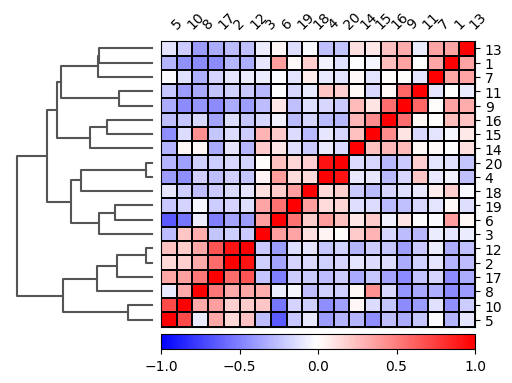

In [11]:
sc.pl.correlation_matrix(adata, tool, figsize=(6,4), show=True)

# [11] Plotting spatial clustering result

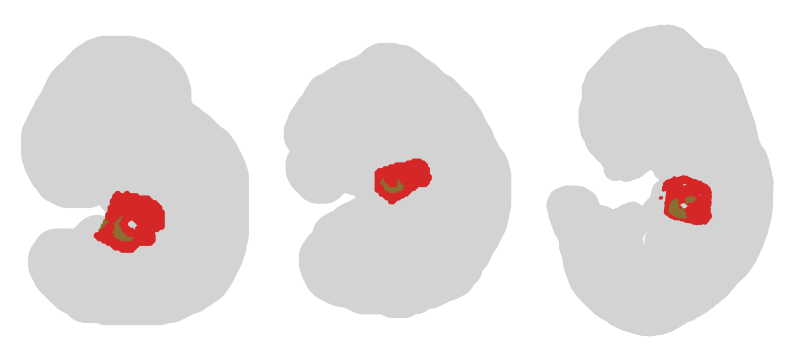

In [12]:
spot_size = 3
title_size = 12
matplotlib.rcParams['font.family'] = 'Arial'     
matplotlib.rcParams['font.size'] = 14  

fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
for idx, name in enumerate(use_sections):
    sub_adata = adata[adata.obs['slice_name'] == name]
    unsub = sub_adata[sub_adata.obs[tool] != "20"]
    unsub = unsub[unsub.obs[tool] != "4"]
    _sc_ = sc.pl.spatial(unsub, img_key=None, color=None, title=[''],
                         legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                         spot_size=20)

    sub = sub_adata[sub_adata.obs[tool] == "20"]
    _sc_ = sc.pl.spatial(sub, img_key=None, color=[tool], title=[''],
                         legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                         spot_size=spot_size)
    sub = sub_adata[sub_adata.obs[tool] == "4"]
    _sc_ = sc.pl.spatial(sub, img_key=None, color=[tool], title=[''],
                         legend_loc=None, legend_fontsize=12, show=False, ax=ax[idx], frameon=False,
                         spot_size=spot_size)
plt.show()

# [12] Spot set of heart area

In [13]:
heart_spot = adata.obs.query('mclust == "20" or mclust == "4"').index.tolist()
heart_adata = adata[heart_spot]

# [13] Draw pseudotime UMAP

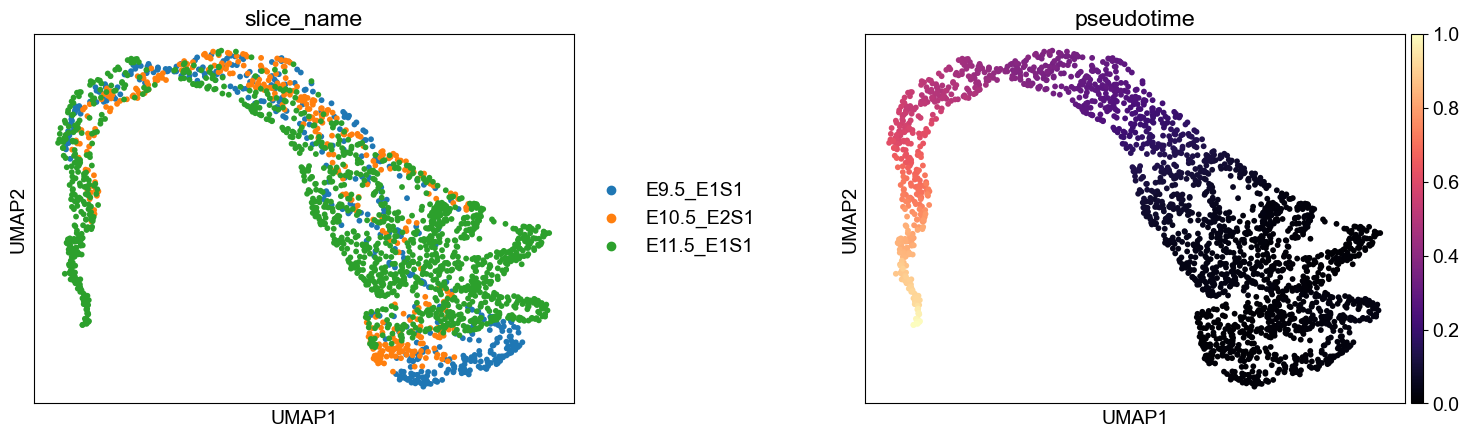

In [14]:
# 1. Construct the neighborhood graph using SpaCross embeddings
sc.pp.neighbors(heart_adata, use_rep='embed', n_neighbors=50, n_pcs=10)
# 2. Optional: Perform dimensionality reduction (e.g., UMAP)
sc.tl.umap(heart_adata)
# 3. Manually define the root cells (e.g., heart region from E9.5)
root_cells = heart_adata.obs[
    (heart_adata.obs['slice_name'] == "E9.5_E1S1") & 
    (heart_adata.obs['mclust'] == '4')
].index
# Select a specific root cell by index
start_idx = 0 
heart_adata.uns['iroot'] = heart_adata.obs_names.get_loc(root_cells[start_idx])
# 4. Perform DPT (Diffusion Pseudotime) analysis
sc.tl.dpt(heart_adata, n_dcs=10, neighbors_key='neighbors')
# Store pseudotime values in the AnnData object
heart_adata.obs['pseudotime'] = heart_adata.obs['dpt_pseudotime']
# 5. Visualize the pseudotime trajectory (e.g., on the UMAP)
sc.pl.umap(
    heart_adata,
    color=["slice_name", "pseudotime"],
    color_map="magma",
    wspace=0.4,
    size=70,
)